# NCAAM 2021 - LGB w/ FE on three Datasets

This notebook is copied from my notebook from NCAAM 2020. It shows LGB model training with feature engineering on three different datasets:
- MRegularSeasonCompactResults
- MRegularSeasonDetailedResults
- MMasseyOrdinals

The engineered features are appended to MNCAATourneyCompactResults and then LGB will be trained on it.

Only Season < 2015 is used for Stage1 training, so there is no leak on the test prediction.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import log_loss
import lightgbm as lgb

For Stage 1, 2003 <= Season < 2015 will be used for the model training/validation and test preditions are calculated by that trained model. For Stage 2, Season >= 2003 will be used for  training.

In [2]:
DATA_DIR = '../input/ncaam-march-mania-2021/MDataFiles_Stage2/'

STAGE_1 = False # This needs to be False when it's stage 2 

## FE on RegularSeasonCompactResults

### Calculating Win %

In [3]:
MRSCResults = pd.read_csv(DATA_DIR + '/MRegularSeasonCompactResults.csv')

A_w = MRSCResults[MRSCResults.WLoc == 'A']\
    .groupby(['Season','WTeamID'])['WTeamID'].count().to_frame()\
    .rename(columns={"WTeamID": "win_A"})
N_w = MRSCResults[MRSCResults.WLoc == 'N']\
    .groupby(['Season','WTeamID'])['WTeamID'].count().to_frame()\
    .rename(columns={"WTeamID": "win_N"})
H_w = MRSCResults[MRSCResults.WLoc == 'H']\
    .groupby(['Season','WTeamID'])['WTeamID'].count().to_frame()\
    .rename(columns={"WTeamID": "win_H"})
win = A_w.join(N_w, how='outer').join(H_w, how='outer').fillna(0)

H_l = MRSCResults[MRSCResults.WLoc == 'A']\
    .groupby(['Season','LTeamID'])['LTeamID'].count().to_frame()\
    .rename(columns={"LTeamID": "lost_H"})
N_l = MRSCResults[MRSCResults.WLoc == 'N']\
    .groupby(['Season','LTeamID'])['LTeamID'].count().to_frame()\
    .rename(columns={"LTeamID": "lost_N"})
A_l = MRSCResults[MRSCResults.WLoc == 'H']\
    .groupby(['Season','LTeamID'])['LTeamID'].count().to_frame()\
    .rename(columns={"LTeamID": "lost_A"})
lost = A_l.join(N_l, how='outer').join(H_l, how='outer').fillna(0)

win.index = win.index.rename(['Season', 'TeamID'])
lost.index = lost.index.rename(['Season', 'TeamID'])
wl = win.join(lost, how='outer').reset_index()
wl['win_pct_A'] = wl['win_A'] / (wl['win_A'] + wl['lost_A'])
wl['win_pct_N'] = wl['win_N'] / (wl['win_N'] + wl['lost_N'])
wl['win_pct_H'] = wl['win_H'] / (wl['win_H'] + wl['lost_H'])
wl['win_pct_All'] = (wl['win_A'] + wl['win_N'] + wl['win_H']) / \
    (wl['win_A'] + wl['win_N'] + wl['win_H'] + wl['lost_A']\
     + wl['lost_N'] + wl['lost_H'])

del A_w, N_w, H_w, H_l, N_l, A_l, win, lost

### Creating Score Features

In [4]:
MRSCResults['relScore'] = MRSCResults.WScore - MRSCResults.LScore

w_scr = MRSCResults.loc[:, ['Season', 'WTeamID', 'WScore', 'WLoc','relScore']]
w_scr.columns = ['Season', 'TeamID','Score','Loc','relScore']
l_scr = MRSCResults.loc[:, ['Season', 'LTeamID', 'LScore', 'WLoc','relScore']]
l_scr['WLoc'] = l_scr.WLoc.apply(lambda x: 'H' if x == 'A' else 'A' \
                                 if x == 'H' else 'N')
l_scr['relScore'] = -1 * l_scr.relScore 
l_scr.columns = ['Season', 'TeamID','Score','Loc','relScore']
wl_scr = pd.concat([w_scr,l_scr])

A_scr = wl_scr[wl_scr.Loc == 'A'].groupby(['Season','TeamID'])\
        ['Score','relScore'].mean()\
        .rename(columns={"Score": "Score_A", "relScore": "relScore_A"})
N_scr = wl_scr[wl_scr.Loc == 'N'].groupby(['Season','TeamID'])\
        ['Score','relScore'].mean()\
        .rename(columns={"Score": "Score_N", "relScore": "relScore_N"})
H_scr = wl_scr[wl_scr.Loc == 'H'].groupby(['Season','TeamID'])\
        ['Score','relScore'].mean()\
        .rename(columns={"Score": "Score_H", "relScore": "relScore_H"})
All_scr = wl_scr.groupby(['Season','TeamID'])['Score','relScore']\
    .mean().rename(columns={"Score": "Score_All", "relScore": "relScore_All"})
scr = A_scr.join(N_scr, how='outer').join(H_scr, how='outer')\
    .join(All_scr, how='outer').fillna(0).reset_index()

del w_scr, l_scr, wl_scr, A_scr, H_scr, N_scr, All_scr

## FE on MRegularSeasonDetailedResults

In [5]:
MRSDetailedResults = pd.read_csv(DATA_DIR + '/MRegularSeasonDetailedResults.csv')

w = MRSDetailedResults.loc[:, ['Season', 'WTeamID', 'WFGM','WFGA','WFGM3'
                               ,'WFGA3','WFTM','WFTA','WOR','WDR','WAst',
                               'WTO','WStl','WBlk','WPF']]
w.columns = ['Season', 'TeamID', 'FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR',
             'Ast','TO','Stl','Blk','PF']
l = MRSDetailedResults.loc[:, ['Season', 'LTeamID', 'LFGM','LFGA','LFGM3',
                               'LFGA3','LFTM','LFTA','LOR','LDR','LAst',
                               'LTO','LStl','LBlk','LPF']]
l.columns = ['Season', 'TeamID', 'FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR',
             'Ast','TO','Stl','Blk','PF']

detail = pd.concat([w,l])
detail['goal_rate'] = detail.FGM / detail.FGA 
detail['3p_goal_rate'] = detail.FGM3 / detail.FGA3  
detail['ft_goal_rate'] = detail.FTM  / detail.FTA  

dt = detail.groupby(['Season','TeamID'])['FGM','FGA','FGM3','FGA3','FTM','FTA',
                                         'OR','DR','Ast','TO','Stl','Blk','PF',
                                          'goal_rate', '3p_goal_rate',
                                         'ft_goal_rate']\
                                        .mean().fillna(0).reset_index()

del w, l, detail

## FE on MMasseyOrdinals

Using only MOR for now.

In [6]:
MMOrdinals = pd.read_csv(DATA_DIR + '/MMasseyOrdinals.csv')

MOR_127_128 = MMOrdinals[(MMOrdinals.SystemName == 'MOR') & \
                ((MMOrdinals.RankingDayNum == 127) \
                 | (MMOrdinals.RankingDayNum == 128))]\
                [['Season','TeamID','OrdinalRank']]
MOR_50_51 = MMOrdinals[(MMOrdinals.SystemName == 'MOR') & \
                ((MMOrdinals.RankingDayNum == 50) \
                 | (MMOrdinals.RankingDayNum == 51))]\
                [['Season','TeamID','OrdinalRank']]
MOR_15_16 = MMOrdinals[(MMOrdinals.SystemName == 'MOR') & \
                ((MMOrdinals.RankingDayNum == 15) \
                 | (MMOrdinals.RankingDayNum == 16))]\
                [['Season','TeamID','OrdinalRank']]

MOR_127_128 = MOR_127_128.rename(columns={'OrdinalRank':'OrdinalRank_127_128'})
MOR_50_51 = MOR_50_51.rename(columns={'OrdinalRank':'OrdinalRank_50_51'})
MOR_15_16 = MOR_15_16.rename(columns={'OrdinalRank':'OrdinalRank_15_16'})

MOR = MOR_127_128.merge(MOR_50_51, how='left', on=['Season','TeamID'])\
        .merge(MOR_15_16, how='left', on=['Season','TeamID'])

## normalizing Rank values by its season maxium as it varies by seasons
MOR_max = MOR.groupby('Season')['OrdinalRank_127_128','OrdinalRank_50_51',
                                'OrdinalRank_15_16'].max().reset_index()
MOR_max.columns = ['Season', 'maxRank_127_128', 'maxRank_50_51', 'maxRank_15_16']

MOR_tmp = MMOrdinals[(MMOrdinals.SystemName == 'MOR') \
                     & (MMOrdinals.RankingDayNum < 133)]
MOR_stats = MOR_tmp.groupby(['Season','TeamID'])['OrdinalRank']\
            .agg(['max','min','std','mean']).reset_index()
MOR_stats.columns = ['Season','TeamID','RankMax','RankMin','RankStd','RankMean']

MOR = MOR.merge(MOR_max, how='left', on='Season')\
        .merge(MOR_stats, how='left', on=['Season','TeamID'])
MOR['OrdinalRank_127_128'] = MOR['OrdinalRank_127_128'] / MOR['maxRank_127_128']
MOR['OrdinalRank_50_51'] = MOR['OrdinalRank_50_51'] / MOR['maxRank_50_51']
MOR['OrdinalRank_15_16'] = MOR['OrdinalRank_15_16'] / MOR['maxRank_15_16']
MOR['RankTrans_50_51_to_127_128'] = MOR['OrdinalRank_127_128'] \
                                    - MOR['OrdinalRank_50_51']
MOR['RankTrans_15_16_to_127_128'] = MOR['OrdinalRank_127_128'] \
                                    - MOR['OrdinalRank_15_16']

# MOR['RankMax'] = MOR['RankMax'] / MOR['maxRank_127_128']
# MOR['RankMin'] = MOR['RankMin'] / MOR['maxRank_127_128']
# MOR['RankStd'] = MOR['RankStd'] / MOR['maxRank_127_128']
# MOR['RankMean'] = MOR['RankMean'] / MOR['maxRank_127_128']

MOR.drop(['OrdinalRank_50_51','OrdinalRank_15_16', 'maxRank_50_51'
          ,'maxRank_15_16'],axis=1, inplace=True)

del MOR_127_128, MOR_50_51, MOR_15_16, MOR_max, MOR_tmp, MOR_stats

In [7]:
# Checking availability on RankingDayNum by SystemName 

# pd.options.display.max_columns=100
# tmp = MMasseyOrdinals[(MMasseyOrdinals.SystemName == 'MOR')]
# pd.crosstab(tmp.Season, tmp.RankingDayNum)

## FE on MNCAATourneySeeds

Seed didn't improve the score, so it's not used.

In [8]:
# MNCAATourneySeeds = pd.read_csv(DATA_DIR + '/MDataFiles_Stage1/MNCAATourneySeeds.csv')
# MNCAATourneySeeds['seed_num'] =  MNCAATourneySeeds.Seed.apply(lambda x: int(x[1:3]))
# MNCAATourneySeeds.drop('Seed', axis=1, inplace=True)

Duplicating each data with changing column names to be matched to 'WTeamID' and 'LTeamID' in Tourney dataset

In [9]:
wl_1 = wl.loc[:,['Season','TeamID','win_pct_A','win_pct_N',
                 'win_pct_H','win_pct_All']]
wl_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                else str(col) for col in wl_1.columns ]

wl_2 = wl.loc[:,['Season','TeamID','win_pct_A','win_pct_N',
                 'win_pct_H','win_pct_All']]
wl_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                else str(col) for col in wl_2.columns ]

scr_1 = scr.copy()
scr_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                 else str(col) for col in scr_1.columns ]

scr_2 = scr.copy()
scr_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                 else str(col) for col in scr_2.columns ]

dt_1 = dt.copy()
dt_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                else str(col) for col in dt_1.columns ]

dt_2 = dt.copy()
dt_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                else str(col) for col in dt_2.columns ]

MOR_1 = MOR.copy()
MOR_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                 else str(col) for col in MOR_1.columns ]

MOR_2 = MOR.copy()
MOR_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                 else str(col) for col in MOR_2.columns ]

## Loading MNCAATourneyCompactResults

This dataset will be the base dataset for the model training

In [10]:
TCResults = pd.read_csv(DATA_DIR + '/MNCAATourneyCompactResults.csv')

tourney1 = TCResults.loc[:, ['Season','WTeamID','LTeamID']]
tourney1.columns = ['Season','TeamID1','TeamID2']
tourney1['result'] = 1

tourney2 = TCResults.loc[:, ['Season','LTeamID','WTeamID']]
tourney2.columns = ['Season','TeamID1','TeamID2']
tourney2['result'] = 0

tourney = pd.concat([tourney1, tourney2])
del tourney1, tourney2

### Merging engineered features to Tourney dataset

In [11]:
def merge_data(df):

    df = df.merge(wl_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(wl_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)


    df = df.merge(scr_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(scr_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)

    # df['win_pct_A_diff'] = df['win_pct_A_1'] - df['win_pct_A_2']
    # df['win_pct_N_diff'] = df['win_pct_N_1'] - df['win_pct_N_2']
    # df['win_pct_H_diff'] = df['win_pct_H_1'] - df['win_pct_H_2']
#     df['win_pct_All_diff'] = df['win_pct_All_1'] - df['win_pct_All_2']

    # df['Score_A_diff'] = df['Score_A_1'] - df['Score_A_2']
    # df['Score_N_diff'] = df['Score_N_1'] - df['Score_N_2']
    # df['Score_H_diff'] = df['Score_H_1'] - df['Score_H_2']
    # df['Score_All_diff'] = df['Score_All_1'] - df['Score_All_2']

    # df['relScore_A_diff'] = df['relScore_A_1'] - df['relScore_A_2']
    # df['relScore_N_diff'] = df['relScore_N_1'] - df['relScore_N_2']
    # df['relScore_H_diff'] = df['relScore_H_1'] - df['relScore_H_2']
#     df['relScore_All_diff'] = df['relScore_All_1'] - df['relScore_All_2']

    df = df.merge(dt_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(dt_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)

    df = df.merge(MOR_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(MOR_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)

    df['OrdinalRank_127_128_diff'] = df['OrdinalRank_127_128_1'] \
        - df['OrdinalRank_127_128_2']
    
    df['magic1'] = df['OrdinalRank_127_128_diff'] - df['RankMean_1']
    df['magic2'] = df['RankMean_1'] - df['RankMean_2']
    df['magic3'] = df['OrdinalRank_127_128_diff'] - df['RankMean_2']
    
    df['magic11'] = df['OrdinalRank_127_128_diff'] * df['RankMean_1']
    df['magic21'] = df['RankMean_1'] * df['RankMean_2']
    df['magic31'] = df['OrdinalRank_127_128_diff'] * df['RankMean_2']
    
    df['magic12'] = df['OrdinalRank_127_128_diff'] / df['RankMean_1']
    df['magic22'] = df['RankMean_1'] / df['RankMean_2']
    df['magic32'] = df['OrdinalRank_127_128_diff'] / df['RankMean_2']

    df = df.fillna(-1)
    
    for col in df.columns:
        if (df[col] == np.inf).any() or (df[col] == -np.inf).any():
            df[col][(df[col] == np.inf) | (df[col] == -np.inf)] = -1
    
    return df

tourney = merge_data(tourney)
tourney = tourney.loc[tourney.Season >= 2003,:].reset_index(drop=True)

if STAGE_1:
    tourney = tourney.loc[tourney.Season < 2015, :]

## Loading Submission Dataset
Duplicating each ID with swapping TeamIDs. Predictions will be averaged by ID to get better performance.

In [12]:
if STAGE_1:
    MSampleSubmission = pd.read_csv(DATA_DIR + '/MSampleSubmissionStage1.csv')
else:
    MSampleSubmission = pd.read_csv(DATA_DIR + '/MSampleSubmissionStage2.csv') # put stage 2 submission file link here

test1 = MSampleSubmission.copy()
test1['Season'] = test1.ID.apply(lambda x: int(x[0:4]))
test1['TeamID1'] = test1.ID.apply(lambda x: int(x[5:9]))
test1['TeamID2'] = test1.ID.apply(lambda x: int(x[10:14]))

test2 = MSampleSubmission.copy()
test2['Season'] = test2.ID.apply(lambda x: int(x[0:4]))
test2['TeamID1'] = test2.ID.apply(lambda x: int(x[10:14]))
test2['TeamID2'] = test2.ID.apply(lambda x: int(x[5:9]))

test = pd.concat([test1,test2]).drop(['Pred'], axis=1)
test = merge_data(test)

## Model Training

In [13]:
X = tourney.drop(['Season','TeamID1','TeamID2','result'], axis=1)
y = tourney["result"]
s = tourney["Season"]

X_test = test.drop(['ID', 'Season','TeamID1','TeamID2'], axis=1)

In [14]:
s.value_counts()

2019    134
2012    134
2015    134
2013    134
2011    134
2017    134
2018    134
2016    134
2014    134
2006    128
2008    128
2010    128
2003    128
2005    128
2007    128
2009    128
2004    128
Name: Season, dtype: int64

In [15]:
def model_training(X, y, cv, groups, params, metric, early_stopping=10, \
    plt_iter=True, X_test=[], cat_features=[]):

    feature_importance = pd.DataFrame()
    val_scores=[]
    train_evals=[]
    valid_evals=[]

    if len(X_test) > 0:
        test_pred=np.zeros(len(X_test))

    for idx, (train_index, val_index) in enumerate(cv.split(X, y, groups)):

        print("###### fold %d ######" % (idx+1))
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = lgb.LGBMClassifier(**params)

        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=early_stopping,
                  verbose=20
                  #categorical_feature=list(cate_ft_lst),
                  )

        val_scores.append(model.best_score_['valid_1'][metric])
        train_evals.append(model.evals_result_['training'][metric])
        valid_evals.append(model.evals_result_['valid_1'][metric])

        if len(X_test) > 0:
            test_pred = test_pred + model.predict_proba(X_test, num_iteration=model.best_iteration_)[:,1]

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X_train.columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = idx+1
        feature_importance = pd.concat([feature_importance, fold_importance]
                                       , axis=0)

    if plt_iter:
        
        fig, axs = plt.subplots(2, 2, figsize=(9,6))
        
        for i, ax in enumerate(axs.flatten()):
            ax.plot(train_evals[i], label='training')
            ax.plot(valid_evals[i], label='validation')
            ax.set(xlabel='interations', ylabel=f'{metric}')
            ax.set_title(f'fold {i+1}', fontsize=12)
            ax.legend(loc='upper right', prop={'size': 9})
        fig.tight_layout()
        plt.show()
    
    print('### CV scores by fold ###')
    for i in range(cv.get_n_splits(X)):
        print(f'fold {i+1}: {val_scores[i]:.4f}')
    print('CV mean score: {0:.4f}, std: {1:.4f}.'\
          .format(np.mean(val_scores), np.std(val_scores)))
    
    feature_importance = feature_importance[["feature", "importance"]]\
                         .groupby("feature").mean().sort_values(
                         by="importance", ascending=False)
    feature_importance.reset_index(inplace=True)

    if len(X_test) > 0:
        test_pred = test_pred / cv.get_n_splits(X)
        return feature_importance, test_pred
    else:
        return feature_importance

In [16]:
lgb_params = {'objective': 'binary',
              'metric': 'binary_logloss',
              'boosting': 'gbdt',
              'num_leaves': 31,
              'feature_fraction': 0.8,
              'bagging_fraction': 0.8,
              'bagging_freq': 5,
              'learning_rate': 0.1,
              'n_estimators': 1000,
}

Using GroupKFold by Season

In [17]:
N_FOLDS = 10

###### fold 1 ######
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.375265	valid_1's binary_logloss: 0.489985
[40]	training's binary_logloss: 0.249831	valid_1's binary_logloss: 0.476567
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.286337	valid_1's binary_logloss: 0.470447
###### fold 2 ######
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.364798	valid_1's binary_logloss: 0.564587
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.326617	valid_1's binary_logloss: 0.560465
###### fold 3 ######
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.365257	valid_1's binary_logloss: 0.60863
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.456195	valid_1's binary_logloss: 0.592449
###### fold 4 ######
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.36

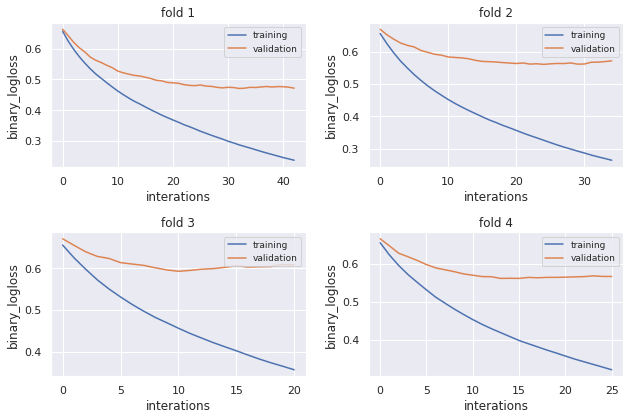

### CV scores by fold ###
fold 1: 0.4704
fold 2: 0.5605
fold 3: 0.5924
fold 4: 0.5613
fold 5: 0.5762
fold 6: 0.6070
fold 7: 0.5574
fold 8: 0.5481
fold 9: 0.5322
fold 10: 0.5570
CV mean score: 0.5562, std: 0.0351.
CPU times: user 8.25 s, sys: 420 ms, total: 8.67 s
Wall time: 4.57 s


In [18]:
%%time
group_kfold = GroupKFold(n_splits=N_FOLDS)

feature_importance, test_pred = \
    model_training(X, y, group_kfold, s, lgb_params, 
    'binary_logloss', plt_iter=True, X_test=X_test)

Text(0.5, 1.0, 'Feature Importnace')

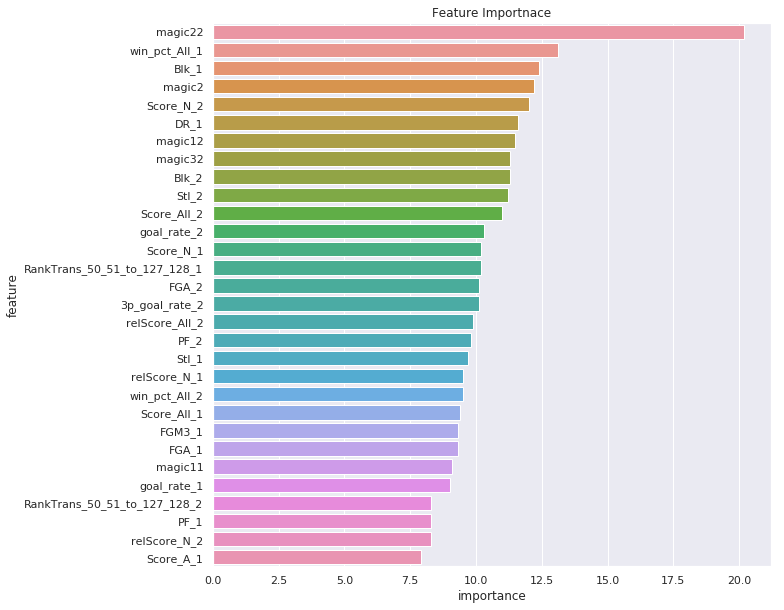

In [19]:
plt.figure(figsize=(10, 10));
sns.barplot(x="importance", y="feature", data=feature_importance[:30])
plt.title('Feature Importnace')

# 2nd model

In [20]:
# # https://www.kaggle.com/joseleiva/massey-s-ordinal-s-ordinals

# import numpy as np
# import pandas as pd

# inp = '../input/ncaam-march-mania-2021/'
# season_df = pd.read_csv(inp+'MRegularSeasonCompactResults.csv')
# tourney_df = pd.read_csv(inp+'MNCAATourneyCompactResults.csv')
# ordinals_df = pd.read_csv(inp+'MMasseyOrdinals.csv').rename(columns={'RankingDayNum':'DayNum'})

# # Get the last available data from each system previous to the tournament
# ordinals_df = ordinals_df.groupby(['SystemName','Season','TeamID']).last().reset_index()

# # Add winner's ordinals
# games_df = tourney_df.merge(ordinals_df,left_on=['Season','WTeamID'],
#                           right_on=['Season','TeamID'])
# games_df.head()
# # Then add losser's ordinals
# games_df = games_df.merge(ordinals_df,left_on=['Season','LTeamID','SystemName'],
#                           right_on=['Season','TeamID','SystemName'],
#                           suffixes = ['W','L'])

# ## Add column with 1 if result is correct
# games_df = games_df.drop(labels=['TeamIDW','TeamIDL'],axis=1)
# games_df['prediction'] = (games_df.OrdinalRankW<games_df.OrdinalRankL).astype(int)
# results_by_system = games_df.groupby('SystemName').agg({'prediction':('mean','count')})

# games_df['Wrating'] = 100-4*np.log(games_df['OrdinalRankW']+1)-games_df['OrdinalRankW']/22
# games_df['Lrating'] = 100-4*np.log(games_df['OrdinalRankL']+1)-games_df['OrdinalRankL']/22
# games_df['prob'] = 1/(1+10**((games_df['Lrating']-games_df['Wrating'])/15))
# loss_results = games_df[games_df.Season>=2015].groupby('SystemName')['prob'].agg([('loss',lambda p: -np.mean(np.log(p))),('count','count')])

# ref_system = 'POM'
# ordinals_df['Rating']= 100-4*np.log(ordinals_df['OrdinalRank']+1)-ordinals_df['OrdinalRank']/22
# ordinals_df = ordinals_df[ordinals_df.SystemName==ref_system]

# # Get submission file
# sub_df = pd.read_csv(inp+'MSampleSubmissionStage1.csv')
# sub_df['Season'] = sub_df['ID'].map(lambda x: int(x.split('_')[0]))
# sub_df['Team1'] = sub_df['ID'].map(lambda x: int(x.split('_')[1]))
# sub_df['Team2'] = sub_df['ID'].map(lambda x: int(x.split('_')[2]))
# sub_df = sub_df.merge(ordinals_df[['Season','TeamID','Rating']], how='left', left_on = ['Season','Team1'], right_on = ['Season','TeamID'])
# sub_df = sub_df.merge(ordinals_df[['Season','TeamID','Rating']], how='left', left_on = ['Season','Team2'], right_on = ['Season','TeamID'], suffixes=['W','L'])

# 3rd model

In [21]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from tqdm.notebook import tqdm
import glob
import os
import gc
import xgboost as xgb

train = tourney
test = test

xgb_params= {
        "objective": "binary:logistic",
        "max_depth": 2,
        "learning_rate": 0.1,
        "colsample_bytree": 0.8,
        "subsample": 0.8,
        #"reg_alpha" : 0,
        "min_child_weight": 30,
        "n_jobs": 2,
        "seed": 2021,
        'tree_method': "gpu_hist",
        "gpu_id": 0,
        'predictor': 'gpu_predictor'
    }

y = train["result"]
s = train["Season"]
X = train.drop(['Season','TeamID1','TeamID2','result'], axis=1)

X_test = test.drop(['ID', 'Season','TeamID1','TeamID2'], axis=1)

train_oof = np.zeros((X.shape[0],))
test_preds = 0
train_oof.shape

NUM_FOLDS = 5
kf = GroupKFold(n_splits=NUM_FOLDS)
max_iter = 550

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X, y, s))):
        #print(f'Fold {f}')
        train_df, val_df = X.iloc[train_ind], X.iloc[val_ind]
        train_target, val_target = y.iloc[train_ind], y.iloc[val_ind]
        train_df_xgb = xgb.DMatrix(train_df, label=train_target)
        val_df_xgb = xgb.DMatrix(val_df, label=val_target)
        
        model = HistGradientBoostingClassifier(max_iter=max_iter, validation_fraction=None, learning_rate=0.01, max_depth=2, min_samples_leaf=32)
        model1 = RandomForestClassifier()
        model2 = LogisticRegression(C=1)
#         model3 = SVC(probability=True)
        model4 = xgb.train(xgb_params, train_df_xgb, 1000)

        model =  model.fit(train_df, train_target)
        model1 =  model1.fit(train_df, train_target)
        model2 =  model2.fit(train_df, train_target)
#         model3 =  model3.fit(train_df, train_target)
          
#         temp_oof = model2.predict_proba(val_df)[:,1]
#         temp_test = model2.predict_proba(X_test)[:,1]
        
        temp_oof = (model.predict_proba(val_df)[:,1] + \
                    model1.predict_proba(val_df)[:,1] + \
                    model2.predict_proba(val_df)[:,1] + \
#                     model3.predict_proba(val_df)[:,1] + \
                    model4.predict(val_df_xgb)) / 4
        temp_test = (model.predict_proba(X_test)[:,1] \
                     + model1.predict_proba(X_test)[:,1] \
                     + model2.predict_proba(X_test)[:,1] \
#                      + model3.predict_proba(X_test)[:,1] \
                     + model4.predict(xgb.DMatrix(X_test))) / 4

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(log_loss(val_target, temp_oof))
        
print('CV', log_loss(y, train_oof))        
np.save('train_oof', train_oof)
np.save('test_preds', test_preds)

test = test
MSampleSubmission = pd.read_csv('../input/ncaam-march-mania-2021/MDataFiles_Stage2/MSampleSubmissionStage2.csv')

idx = test_preds.shape[0] //2
test_preds[idx:] = 1 - test_preds[idx:]

pred = pd.concat([test.ID, pd.Series(test_preds)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub3 = MSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
pred_3 = sub3['Pred']

0.5308707696972911
0.5330772038679964
0.5805150822286625
0.5411138736285539
0.5547863673645453

CV 0.5474525833486096


In [22]:
0.5539459504635523

0.5539459504635523

## Creating Submission File

The second half of the test prediction need to be (1 - pred) as the team order was swapped. The predictions are averaged by ID after that.

In [23]:
idx = test_pred.shape[0] //2
test_pred[idx:] = 1 - test_pred[idx:]

pred = pd.concat([test.ID, pd.Series(test_pred)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub = MSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
sub['Pred'] = sub['Pred'] * 0.3 + sub3['Pred'] * 0.7
sub.to_csv('submission.csv', index=False)
sub.head()

,ID,Pred
0,2021_1101_1104,0.292578
1,2021_1101_1111,0.807139
2,2021_1101_1116,0.270697
3,2021_1101_1124,0.153285
4,2021_1101_1140,0.480314


## Calculating Test Score Locally

In [24]:
if STAGE_1:
    rslt = pd.DataFrame()
    TCResults_s = TCResults.loc[TCResults.Season >= 2015,:]
    rslt['season'] = TCResults_s.Season
    rslt['team1'] = TCResults_s.apply(lambda x: x.WTeamID \
                                      if x.WTeamID < x.LTeamID else x.LTeamID
                                      , axis=1)
    rslt['team2'] = TCResults_s.apply(lambda x: x.WTeamID \
                                      if x.WTeamID > x.LTeamID else x.LTeamID
                                      , axis=1)
    rslt['wl'] = TCResults_s.apply(lambda x: 1 if x.WTeamID < x.LTeamID else 0
                                   , axis=1)
    rslt['ID'] = rslt.apply(lambda x: str(x.season) + '_' + str(x.team1) \
                            + '_' + str(x.team2), axis=1)
    sub2 = sub.merge(rslt.loc[:,['ID','wl']], how='inner', on='ID')

    preds = []
    for i in sub2.Pred:
        preds.append([1-i, i])

    print('Test logloss is {:.5f}'.format(log_loss(sub2.wl.values, preds)))

In [25]:
0.51971

0.51971